# Цель Блокнота

Решение задачи регрессии в scikit-learn с метода опорных векторов для регрессии
* Обучение класса `SCR` и анализ атрибутов
* Анализ модели для разных данных
* Предобразование целевой переменной с помощью класса `TransformedTargetRegressor`
* оптимизация гиперпараметров с использованием подхода случайного поиска `RandomizedSearchCV`
* Сохранение модели

# Import библиотек

In [ ]:
# @title Гигантский блок импорта  { display-mode: "form" }
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодирование от scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных


from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

In [ ]:
plt.style.use('dark_background') # для модных черных рисунков

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных


Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на GitHub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_no_dup_no_outliers.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

Предварительная обработка из [предыдущего блокнота](https://colab.research.google.com/drive/1es_OrShFiuaeOnlPjX2B1geHDM-XfofM?usp=sharing)

Из предварительной обработки исключена колонка `Price(euro)`, поскольку она является целевой меткой и будет обработана отдельно


In [ ]:
# @title Всякие там Pipeline { display-mode: "form" }

class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('power', PowerTransformer())
])

num_year = ['Year']

cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_make = ['Make']

cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_model = ['Model']

# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_distance,
                    num_engine,
                    num_year,])

In [ ]:
# @title Вспомогательные функции { display-mode: "form" }
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])


def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)


def analyse_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule):

    for name, metric,  in zip(metric_names, metrics):
        print(name+ f" на тренировочной выборке: {calculate_metric(model, X_train, y_train, metric):.4f}")
        print(name+ f" на валидационной выборке: {calculate_metric(model, X_val, y_val, metric):.4f}")
    print('--.--')
    cross_validation (X_train, y_train,
                    model,
                    scoring_reg,
                    cv_rule)

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

cv_rule = ShuffleSplit(n_splits=5, random_state = 42)

metrics = [mse, r2_score]

metric_names = ['mse', 'r2_score']

# Линейная Регрессия

In [ ]:
from sklearn.svm import SVR # Метод опорных векторов для регрессии scikit-learn

**Считываем данные, разбиваем на тестовую и тренировочную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X,y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X[::3], y[::3],
                                                    test_size=0.3,
                                                    random_state=42)

# Оценим модель с использованием только числовых данных

**Преобразуем данные**

In [ ]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

**Обучаем модель**



Стандартная уже для нас рутина

* Создаем объект класса
* "Обучаем" через `.fit`

In [ ]:
model = SVR()

model.fit(X_train_prep, y_train);

Найденные опорные вектора

Т.к. это наиболее спорные точки то на них можно (в теории) внимательней посмотреть

In [ ]:
model.support_

array([   0,    1,    2, ..., 7577, 7578, 7579], dtype=int32)

In [ ]:
model.support_vectors_

array([[ 0.86980555,  0.10089865, -0.39423797],
       [-0.23922828,  3.75810152, -0.66645525],
       [-0.66273753, -1.0121631 ,  0.66255382],
       ...,
       [-0.26842761,  0.57792511,  1.16963154],
       [ 0.3555729 , -0.38407825,  0.03811525],
       [ 1.38295675, -0.05811017, -0.25339566]])

Для этой конфигурации модели мы нашли столько опорных векторов

In [ ]:
len(model.support_)

7578

Сделаем анализ модели

In [ ]:
analyse_model(model,
              X_train_prep, y_train,
              X_val_prep, y_val,
              metrics, metric_names,
              scoring_reg, cv_rule)

mse на тренировочной выборке: 61791013.1680
mse на валидационной выборке: 60428509.4635
r2_score на тренировочной выборке: 0.0089
r2_score на валидационной выборке: 0.0066
--.--
Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,4.645615,0.503111,0.011161,-6.159128e+07,-4805.580234,-38121.213016
1,4.587081,0.528328,0.011916,-6.204823e+07,-4910.304971,-42303.043214
2,3.950329,0.489623,-0.015895,-6.309933e+07,-5028.272071,-41947.628256
3,4.421489,0.518167,-0.009281,-5.776619e+07,-4845.649504,-40445.388524
4,3.180167,0.307003,-0.008599,-6.455790e+07,-5092.719673,-38931.583529




test_R2     -2.139666e-03
test_-MSE   -6.181259e+07
test_-MAE   -4.936505e+03
test_-Max   -4.034977e+04
dtype: float64


## Визуализация ошибок от scikit-learn

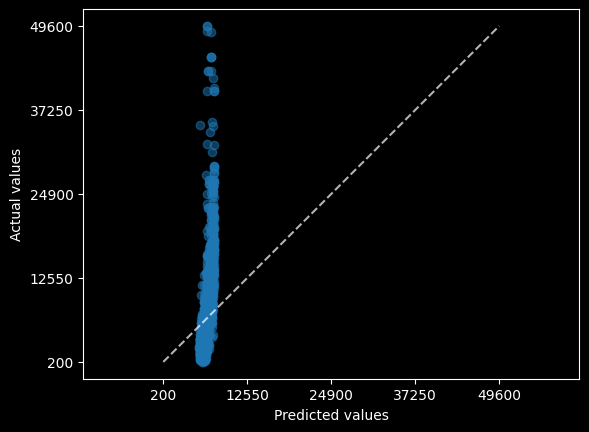

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    line_kwargs = {"color" : 'white'}

);

Небольшие выводы по модели:

Что-то гиперпараметры по умолчанию не работают...

## Покрутим ядро

In [ ]:
#@title **Параметры Метода Опорных векторов** { run: "auto" }
#@markdown ### Margin / Зазор
epsilon=742#@param {type:"slider", min:1, max:1000, step:1}
#@markdown ### Константа регуляризации
C=75 #@param {type:"slider", min:25, max:250, step:25}

#@markdown ### Параметры Ядер
kernel = 'poly'  #@param [ 'rbf' , 'linear', 'poly']{type:"string"}
coef0=0.5 #@param {type:"slider", min:0, max:5, step:0.5}
degree=4 #@param {type:"slider", min:1, max:5, step:1}
gamma=0.95 #@param {type:"slider", min:0.00, max:1, step:0.05}

if gamma == 0:
  gamma='auto'

model_kernel=SVR(kernel=kernel, epsilon=epsilon, C=C, gamma=gamma,
            degree=degree, coef0 = coef0)

In [ ]:
model_kernel.fit(X_train_prep, y_train);

In [ ]:
analyse_model(model_kernel,
              X_train_prep, y_train,
              X_val_prep, y_val,
              metrics, metric_names,
              scoring_reg, cv_rule)

mse на тренировочной выборке: 17239678.6722
mse на валидационной выборке: 17172923.0702
r2_score на тренировочной выборке: 0.7235
r2_score на валидационной выборке: 0.7177
--.--
Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,28.364313,0.081637,0.742814,-1.601920e+07,-2351.588694,-26973.656792
1,16.398388,0.095613,0.709354,-1.825157e+07,-2522.395540,-37031.122854
2,21.294508,0.149796,0.688742,-1.933285e+07,-2536.642219,-48953.797681
3,13.938036,0.095048,0.732234,-1.532557e+07,-2429.568879,-29140.739631
4,16.437468,0.083791,0.744593,-1.634800e+07,-2442.172736,-37360.085086




test_R2      7.235474e-01
test_-MSE   -1.705543e+07
test_-MAE   -2.456474e+03
test_-Max   -3.589188e+04
dtype: float64


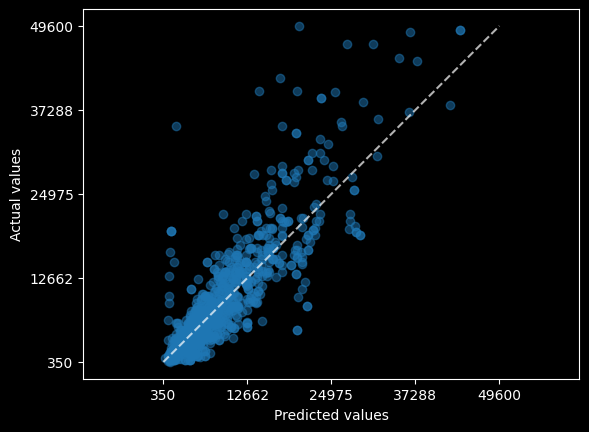

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_kernel.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    line_kwargs = {"color" : 'white'}

);

Небольшие выводы по модели:

* а вот тут интересней - мы получили точность сопоставимую с линейной регрессие С предварительной обработкой целевой переменной И добавлением категориальных признаков
* но что-то долго считает (((

## Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска

In [ ]:
C_range = loguniform(1e-1, 1e3)
gamma_range = loguniform(1e-2, 1e0)
C_range_poly = loguniform(1e-1, 1e2)
epsilon = stats.uniform(10, 1000)
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gamma_range,
                     'C': C_range, 'epsilon': epsilon},
                    {'kernel': ['poly'], 'degree': [2,3,4,5,6], 'C': C_range_poly, 'epsilon': epsilon}]


n_iter_search = 20
SVR_search = RandomizedSearchCV(estimator = SVR(coef0=0.5), verbose = 3,
                          param_distributions=tuned_parameters ,
                          cv=ShuffleSplit(n_splits=5, random_state=42),
                                n_iter = n_iter_search)

SVR_search.fit(X_train_prep, y_train)

SVRbest=SVR_search.best_estimator_

SVRbest.fit(X_train_prep, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.10892525886357209, epsilon=49.96220897601543, gamma=0.30672424769677203, kernel=rbf;, score=-0.068 total time=   2.7s
[CV 2/5] END C=0.10892525886357209, epsilon=49.96220897601543, gamma=0.30672424769677203, kernel=rbf;, score=-0.068 total time=   2.6s
[CV 3/5] END C=0.10892525886357209, epsilon=49.96220897601543, gamma=0.30672424769677203, kernel=rbf;, score=-0.098 total time=   3.9s
[CV 4/5] END C=0.10892525886357209, epsilon=49.96220897601543, gamma=0.30672424769677203, kernel=rbf;, score=-0.088 total time=   2.7s
[CV 5/5] END C=0.10892525886357209, epsilon=49.96220897601543, gamma=0.30672424769677203, kernel=rbf;, score=-0.086 total time=   2.6s
[CV 1/5] END C=1.3379572700080014, degree=4, epsilon=944.5733129120504, kernel=poly;, score=0.389 total time=   1.8s
[CV 2/5] END C=1.3379572700080014, degree=4, epsilon=944.5733129120504, kernel=poly;, score=0.339 total time=   1.8s
[CV 3/5] END C=1.337957270008

**Лучший результат достигается:**

In [ ]:
SVRbest

SVR(C=97.61085733516542, coef0=0.5, degree=5, epsilon=212.78971544493552,
    kernel='poly')

In [ ]:
analyse_model(SVRbest,
              X_train_prep, y_train,
              X_val_prep, y_val,
              metrics, metric_names,
              scoring_reg, cv_rule)

mse на тренировочной выборке: 17084294.8890
mse на валидационной выборке: 17868890.5225
r2_score на тренировочной выборке: 0.7260
r2_score на валидационной выборке: 0.7062
--.--
Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,8.228941,0.193725,0.740372,-1.617129e+07,-2384.486351,-27210.584833
1,4.339754,0.106186,0.733518,-1.673417e+07,-2493.589465,-24118.237785
2,4.991779,0.103743,0.737959,-1.627591e+07,-2513.291101,-29766.761849
3,5.728190,0.103903,0.728048,-1.556519e+07,-2524.601859,-28775.512226
4,3.909977,0.117381,0.738013,-1.676916e+07,-2472.793104,-37095.903656




test_R2      7.355818e-01
test_-MSE   -1.630314e+07
test_-MAE   -2.477752e+03
test_-Max   -2.939340e+04
dtype: float64


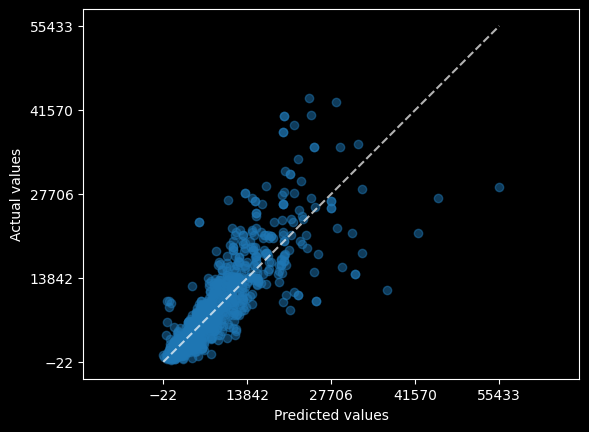

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    SVRbest.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    line_kwargs = {"color" : 'white'}

);

**Опорные Вектора**

In [ ]:
SVRbest.support_vectors_.shape

(6947, 3)

**Рассмотрим результаты перебора**

In [ ]:
DF_reg=pd.DataFrame(SVR_search.cv_results_)
DF = DF_reg[['param_C','param_epsilon','param_kernel','param_degree','param_gamma',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_C,param_epsilon,param_kernel,param_degree,param_gamma,mean_test_score,std_test_score,rank_test_score
6,97.610857,212.789715,poly,5,nan,0.735582,0.004371,1
18,76.421499,738.435453,poly,3,nan,0.697782,0.023013,2
16,59.931106,343.076145,poly,6,nan,0.669124,0.062529,3
7,21.804324,561.955894,poly,6,nan,0.636870,0.042150,4
17,119.652890,150.315692,rbf,nan,0.826318,0.626431,0.009308,5
2,4.442474,339.854909,poly,2,nan,0.482858,0.007865,6
4,31.473569,81.526861,rbf,nan,0.644022,0.480550,0.010832,7
13,32.736023,591.359036,rbf,nan,0.913209,0.446791,0.011199,8
11,2.018473,678.047111,poly,6,nan,0.444569,0.016379,9
10,58.437205,212.946530,rbf,nan,0.017391,0.426522,0.007033,10


Небольшие выводы по модели:

* вот так всегда - сам случайно натыкаешь хорошие гиперпараметры, а при поиске - всё работает хуже, на то он и рандом
* это значит что необходимо задавать больше итераций поиска гиперпараметров (либо ограничиться диапазоном "около" ранее рассмотренных значений)
* тут опять же важно не только само ядро, но и гиперпараметры к нему
* кривыми гиперпараметрами можно модель сломать
    * модели не нравится небольшие значения `C`